**Brian Blaylock**  
**December 12, 2018**

# FLAME Equation Method

[FireLine Assessment MEthod (FLAME)](https://www.fs.fed.us/rm/pubs/rmrs_p046/rmrs_p046_027_074.pdf)


|Type|Equation for Rate Change/Hour  | Wind Speed Correction |
|----|--------|--|
| Grass|\begin{equation}y = 14.384x^{1.2321}\end{equation}| 0.75x|
| Crown|\begin{equation}y = 4.8706x^{1.1456}\end{equation}| 1x|
| Litter|\begin{equation}y = 1.0273x^{1.2128}\end{equation}| 0.25x|

Where x is the wind speed in MPH and y is the r ch/hr

___

## MODIS and HRRR Landuse Classification

* indicates not in HRRR file

|Value|Label|Fuel|Threshold|
|--|--|--|--|
|1|Evergreen Needleleaf forest|Litter/Crown|?|
|2|Evergreen Broadleaf forest|Litter/Crown|?|
|3|Deciduous Needleleaf forest|Litter|
|4|Deciduous Broadleaf forest|Litter|
|5|Mixed forest|Litter/Crown|?|
|6|Closed shrublands|Litter/Crown|?|
|7|Open shrublands|Grass|
|8|Woody savannas|Grass| 
|9|Savannas|Grass|
|10|Grasslands|Grass|
|11|Permanent wetlands|Barrier|
|12|Croplands|Barrier/Grass|?|
|13|Urban and built-up|Barrier|
|14|Cropland/Natural vegetation mosaic|Barrier/Grass|?|
|15|Snow and ice|Barrier| 
|16|Barren or sparsely vegetated|Barrier|
|17|Water|Barrier|
|18|Wooded Tundra|Crown|
|19|Mixed Tundra|Grass| 
|20|*Barren Tundra|Barrier|
|21|*Lake|Barrier|

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

import sys
sys.path.append('/uufs/chpc.utah.edu/common/home/u0553130/pyBKB_v3')
from BB_HRRR.HRRR_Pando import get_hrrr_variable
from BB_cmap.landuse_colormap import LU_MODIS21

# FLAME equations

In [2]:
speeds = np.arange(0,20,.1)

R_grass = 14.384 * (speeds*.75)**1.2321
R_crown = 4.8706 * (speeds*1)**4.8706
R_litter = 1.0273 * (speeds*.25)**1.2128

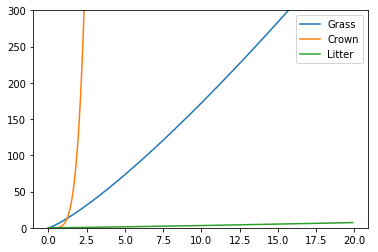

In [3]:
plt.plot(speeds, R_grass, label='Grass')
plt.plot(speeds, R_crown, label='Crown')
plt.plot(speeds, R_litter, label='Litter')
plt.ylim(0,300)
plt.legend()

# HRRR Landuse

In [4]:
landuse = LU_MODIS21()

In [5]:
DATE = datetime(2018, 12, 1)
H = get_hrrr_variable(DATE, variable='VGTYP:surface')


 >> Dowloading tempfile: ./temp_hrrr_2018120100_f00_VGT.grib2
Oh, good, you requested a date that should be on Pando.
GRIB2 File: https://pando-rgw01.chpc.utah.edu/hrrr/sfc/20181201/hrrr.t00z.wrfsfcf00.grib2
 .idx File: https://pando-rgw01.chpc.utah.edu/hrrr/sfc/20181201/hrrr.t00z.wrfsfcf00.grib2.idx
 >> Matched a variable:  93:54342445:d=2018120100:VGTYP:surface:anl:
 >> Byte Range: 54342445 55123270
  Run Date: 2018-12-01 00:00 UTC F00
Valid Date: 2018-12-01 00:00 UTC


In [6]:
np.sum(H['value']==1)

99527

In [28]:
for i, index in enumerate(landuse['index']):
    count = np.sum(H['value']==index)
    print('%2.3f%% for %s' % (100*count/np.size(H['value']), landuse['labels'][i]))

5.224% for Evergreen Needleleaf Forest
0.215% for Evergreen Broadleaf Forest
0.026% for Deciduous Needleleaf Forest
2.566% for Deciduous Broadleaf Forest
8.467% for Mixed Forests
0.127% for Closed Shrublands
8.199% for Open Shrublands
4.146% for Woody Savannas
0.126% for Savannas
16.136% for Grasslands
0.734% for Permanent Wetlands
8.986% for Croplands
0.733% for Urban and Built-Up
6.553% for Cropland/Natural Vegetation Mosaic
0.371% for Snow and Ice
0.780% for Barren or Sparsely Vegetated
36.596% for Water
0.015% for Wooded Tundra
0.000% for Mixed Tundra
0.000% for Barren Tundra
0.000% for Lake


In [33]:
np.histogram(H['value'], bins=landuse['index'])

(array([ 99527,   4090,    501,  48879, 161316,   2428, 156210,  78984,
          2395, 307409,  13986, 171196,  13961, 124837,   7061,  14867,
        697211,    279,      4,      0]),
 array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21]))

/uufs/chpc.utah.edu/common/home/u0553130/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


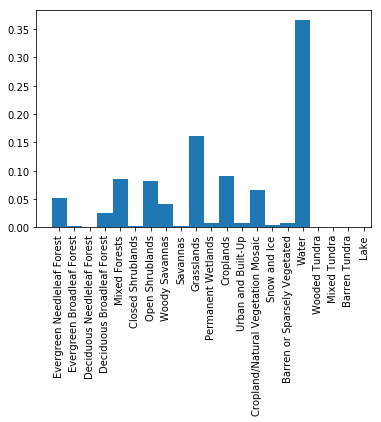

In [92]:
plt.hist(H['value'].flatten(), bins=landuse['index'], normed=True)
plt.xticks(np.array(landuse['index'])+.5, landuse['labels'],rotation=90);

In [44]:
H['value'].flatten()

array([17., 17., 17., ..., 17., 17., 17.], dtype=float32)

In [13]:
np.size(H['value'])

1905141

In [83]:
colors = [i for i in landuse['cmap'].colors]

In [84]:
colors

[array([0. , 0.4, 0. ]),
 array([0. , 0.4, 0.2]),
 array([0.2, 0.8, 0.2]),
 array([0.2, 0.8, 0.4]),
 array([0.2, 0.6, 0.2]),
 array([0.3, 0.7, 0. ]),
 array([0.82, 0.41, 0.12]),
 array([0.74, 0.71, 0.41]),
 array([1.  , 0.84, 0.  ]),
 array([0., 1., 0.]),
 array([0., 1., 1.]),
 array([1., 1., 0.]),
 array([1., 0., 0.]),
 array([0.7, 0.9, 0.3]),
 array([1., 1., 1.]),
 array([0.914, 0.914, 0.7  ]),
 array([0.5, 0.7, 1. ]),
 array([1.  , 0.  , 0.74]),
 array([0.97, 0.5 , 0.31]),
 array([0.91, 0.59, 0.48]),
 array([0.  , 0.  , 0.88])]

In [76]:
len(landuse['index'])

21

In [77]:
len(colors)

21